# Cross-Reference EDA: Electricity & Water Access in SSA
## Correlation, Patterns, Outliers & Noteworthy Data Points
## **Now with Population Data: Absolute Impact Numbers**

---

**Datasets:**
1. Urban Electricity (EG.ELC.ACCS.UR.ZS)
2. Rural Electricity (EG.ELC.ACCS.RU.ZS)
3. Urban Water (JMP)
4. Rural Water (JMP)
5. **Urban Population (SP.URB.TOTL)**
6. **Rural Population (SP.RUR.TOTL)**

---

## Table of Contents
1. [Data Loading & Cleaning](#1-cleaning)
2. [Merged Dataset Overview](#2-overview)
3. [Correlation Analysis](#3-correlation)
4. [Outlier Detection](#4-outliers)
5. [Pattern Analysis](#5-patterns)
6. [Noteworthy Data Points](#6-noteworthy)
7. [**Population Impact Analysis**](#7-population) ← NEW
8. [Key Findings](#8-findings)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Libraries loaded!")

Libraries loaded!


---
# 1. Data Loading & Cleaning <a id='1-cleaning'></a>

In [2]:
# SSA Countries list
ssa_countries = [
    "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi",
    "Cabo Verde", "Cameroon", "Central African Republic",
    "Chad", "Comoros", "Congo", "Côte d'Ivoire",
    "Democratic Republic of the Congo", "Djibouti",
    "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia",
    "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau",
    "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi",
    "Mali", "Mauritania", "Mauritius", "Mozambique",
    "Namibia", "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe",
    "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa",
    "South Sudan", "Sudan", "Togo", "Tanzania",
    "Uganda", "Zambia", "Zimbabwe"
]

# Name mappings
wb_to_ssa = {
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Congo, Rep.": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Gambia, The": "Gambia"
}

jmp_to_ssa = {
    "United Republic of Tanzania": "Tanzania",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Swaziland": "Eswatini"
}

print(f"SSA Countries: {len(ssa_countries)}")

SSA Countries: 49


In [3]:
# Load and process electricity data
def load_wb_data(filepath, indicator_name):
    df = pd.read_csv(filepath, skiprows=4)
    year_cols = [str(y) for y in range(2000, 2023)]  # Common period
    available = [y for y in year_cols if y in df.columns]
    
    df_long = df[['Country Name'] + available].melt(
        id_vars=['Country Name'],
        value_vars=available,
        var_name='Year',
        value_name=indicator_name
    )
    df_long['Year'] = df_long['Year'].astype(int)
    df_long['Country Name'] = df_long['Country Name'].replace(wb_to_ssa)
    df_long = df_long[df_long['Country Name'].isin(ssa_countries)]
    return df_long.rename(columns={'Country Name': 'Country'})

# Load electricity data
df_urban_elec = load_wb_data('../csv/API_EG.ELC.ACCS.UR.ZS_DS2_en_csv_v2_252729.csv', 'Urban_Elec')
df_rural_elec = load_wb_data('../csv/API_EG.ELC.ACCS.RU.ZS_DS2_en_csv_v2_6060.csv', 'Rural_Elec')

print(f"Urban Elec: {df_urban_elec.shape}")
print(f"Rural Elec: {df_rural_elec.shape}")

Urban Elec: (1104, 3)
Rural Elec: (1104, 3)


In [4]:
# Load water data from JMP
df_water_raw = pd.read_excel('../xls/JMP_2025_WLD.xlsx', sheet_name='Water', header=1)

df_water = pd.DataFrame({
    'Country': df_water_raw.iloc[:, 0],
    'Year': pd.to_numeric(df_water_raw.iloc[:, 1], errors='coerce'),
    'Rural_Water': pd.to_numeric(df_water_raw.iloc[:, 4], errors='coerce'),
    'Urban_Water': pd.to_numeric(df_water_raw.iloc[:, 9], errors='coerce')
})

df_water = df_water[df_water['Country'] != 'COUNTRY, AREA OR TERRITORY']
df_water = df_water.dropna(subset=['Year'])
df_water['Year'] = df_water['Year'].astype(int)
df_water['Country'] = df_water['Country'].replace(jmp_to_ssa)
df_water = df_water[df_water['Country'].isin(ssa_countries)]

print(f"Water Data: {df_water.shape}")

Water Data: (1196, 4)


In [5]:
# Load Population Data (Urban and Rural)
# Using the same load_wb_data function

df_urban_pop = load_wb_data('../csv/API_SP.URB.TOTL_DS2_en_csv_v2_10311.csv', 'Urban_Pop')
df_rural_pop = load_wb_data('../csv/API_SP.RUR.TOTL_DS2_en_csv_v2_14806.csv', 'Rural_Pop')

print(f"Urban Population: {df_urban_pop.shape}")
print(f"Rural Population: {df_rural_pop.shape}")
print(f"\nSample urban pop data:")
print(df_urban_pop.head())

Urban Population: (1104, 3)
Rural Population: (1104, 3)

Sample urban pop data:
         Country  Year  Urban_Pop
4         Angola  2000  8111524.0
16       Burundi  2000   533532.0
18         Benin  2000  2768263.0
19  Burkina Faso  2000  2127994.0
33      Botswana  2000   892686.0


In [6]:
# Merge all datasets including population
df_merged = df_urban_elec.merge(df_rural_elec, on=['Country', 'Year'], how='outer')
df_merged = df_merged.merge(df_water, on=['Country', 'Year'], how='outer')
df_merged = df_merged.merge(df_urban_pop, on=['Country', 'Year'], how='left')
df_merged = df_merged.merge(df_rural_pop, on=['Country', 'Year'], how='left')

print(f"Merged Shape: {df_merged.shape}")
print(f"Countries: {df_merged['Country'].nunique()}")
print(f"Years: {df_merged['Year'].min()} - {df_merged['Year'].max()}")

Merged Shape: (1219, 8)
Countries: 49
Years: 2000 - 2024


In [7]:
# DATA CLEANING - Check for issues
print("=" * 60)
print("DATA QUALITY ASSESSMENT")
print("=" * 60)

print("\n--- Missing Values ---")
missing = df_merged[['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']].isnull().sum()
missing_pct = (missing / len(df_merged) * 100).round(1)
print(pd.DataFrame({'Missing': missing, 'Percent': missing_pct}))

print("\n--- Value Ranges (should be 0-100) ---")
for col in ['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']:
    valid = df_merged[col].dropna()
    print(f"{col}: min={valid.min():.1f}, max={valid.max():.1f}")

DATA QUALITY ASSESSMENT

--- Missing Values ---
             Missing  Percent
Urban_Elec       122     10.0
Rural_Elec       257     21.1
Urban_Water       78      6.4
Rural_Water       73      6.0

--- Value Ranges (should be 0-100) ---
Urban_Elec: min=3.5, max=100.0
Rural_Elec: min=0.5, max=100.0
Urban_Water: min=48.1, max=99.0
Rural_Water: min=7.5, max=87.0


In [8]:
# DATA CLEANING - Fix any issues
print("=" * 60)
print("DATA CLEANING STEPS")
print("=" * 60)

# 1. Cap values at 0-100 range
for col in ['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']:
    before = df_merged[col].copy()
    df_merged[col] = df_merged[col].clip(0, 100)
    changed = (before != df_merged[col]).sum()
    if changed > 0:
        print(f"Clipped {changed} values in {col} to 0-100 range")

# 2. Check for logical inconsistencies (Urban should generally >= Rural for same service)
# This is expected - just flagging
elec_reverse = df_merged[df_merged['Rural_Elec'] > df_merged['Urban_Elec']].dropna(subset=['Rural_Elec', 'Urban_Elec'])
water_reverse = df_merged[df_merged['Rural_Water'] > df_merged['Urban_Water']].dropna(subset=['Rural_Water', 'Urban_Water'])
print(f"\nRows where Rural > Urban (Electricity): {len(elec_reverse)}")
print(f"Rows where Rural > Urban (Water): {len(water_reverse)}")

# 3. Create derived columns
df_merged['Elec_Gap'] = df_merged['Urban_Elec'] - df_merged['Rural_Elec']
df_merged['Water_Gap'] = df_merged['Urban_Water'] - df_merged['Rural_Water']
df_merged['Total_Elec'] = (df_merged['Urban_Elec'] + df_merged['Rural_Elec']) / 2
df_merged['Total_Water'] = (df_merged['Urban_Water'] + df_merged['Rural_Water']) / 2

print("\nDerived columns created: Elec_Gap, Water_Gap, Total_Elec, Total_Water")

DATA CLEANING STEPS
Clipped 122 values in Urban_Elec to 0-100 range
Clipped 257 values in Rural_Elec to 0-100 range
Clipped 78 values in Urban_Water to 0-100 range
Clipped 73 values in Rural_Water to 0-100 range

Rows where Rural > Urban (Electricity): 12
Rows where Rural > Urban (Water): 0

Derived columns created: Elec_Gap, Water_Gap, Total_Elec, Total_Water


In [9]:
# Save clean merged dataset
df_merged.to_csv('../csv/ssa_all_indicators_merged_clean.csv', index=False)
print("Clean merged dataset saved: ssa_all_indicators_merged_clean.csv")
print(f"\nFinal dataset: {df_merged.shape[0]} rows, {df_merged.shape[1]} columns")

Clean merged dataset saved: ssa_all_indicators_merged_clean.csv

Final dataset: 1219 rows, 12 columns


---
# 2. Merged Dataset Overview <a id='2-overview'></a>

In [10]:
# Complete cases for correlation analysis
df_complete = df_merged.dropna(subset=['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water'])
print(f"Complete cases (all 4 indicators): {len(df_complete)}")
print(f"Countries with complete data: {df_complete['Country'].nunique()}")
print(f"Year range: {df_complete['Year'].min()} - {df_complete['Year'].max()}")

Complete cases (all 4 indicators): 899
Countries with complete data: 46
Year range: 2000 - 2022


In [11]:
# Summary statistics
print("=" * 60)
print("SUMMARY STATISTICS (Complete Cases)")
print("=" * 60)
print(df_complete[['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water', 'Elec_Gap', 'Water_Gap']].describe().round(1))

SUMMARY STATISTICS (Complete Cases)
       Urban_Elec  Rural_Elec  Urban_Water  Rural_Water  Elec_Gap  Water_Gap
count       899.0       899.0        899.0        899.0     899.0      899.0
mean         66.3        20.9         82.9         49.7      45.4       33.2
std          21.5        20.5          9.4         16.3      18.2       12.9
min           7.2         0.5         48.1          8.8      -8.2        1.6
25%          51.6         4.7         76.8         37.4      34.5       23.8
50%          69.7        15.2         84.3         49.8      45.9       32.5
75%          84.8        30.8         89.7         61.5      57.6       42.7
max         100.0        96.9         99.0         87.0      87.7       67.9


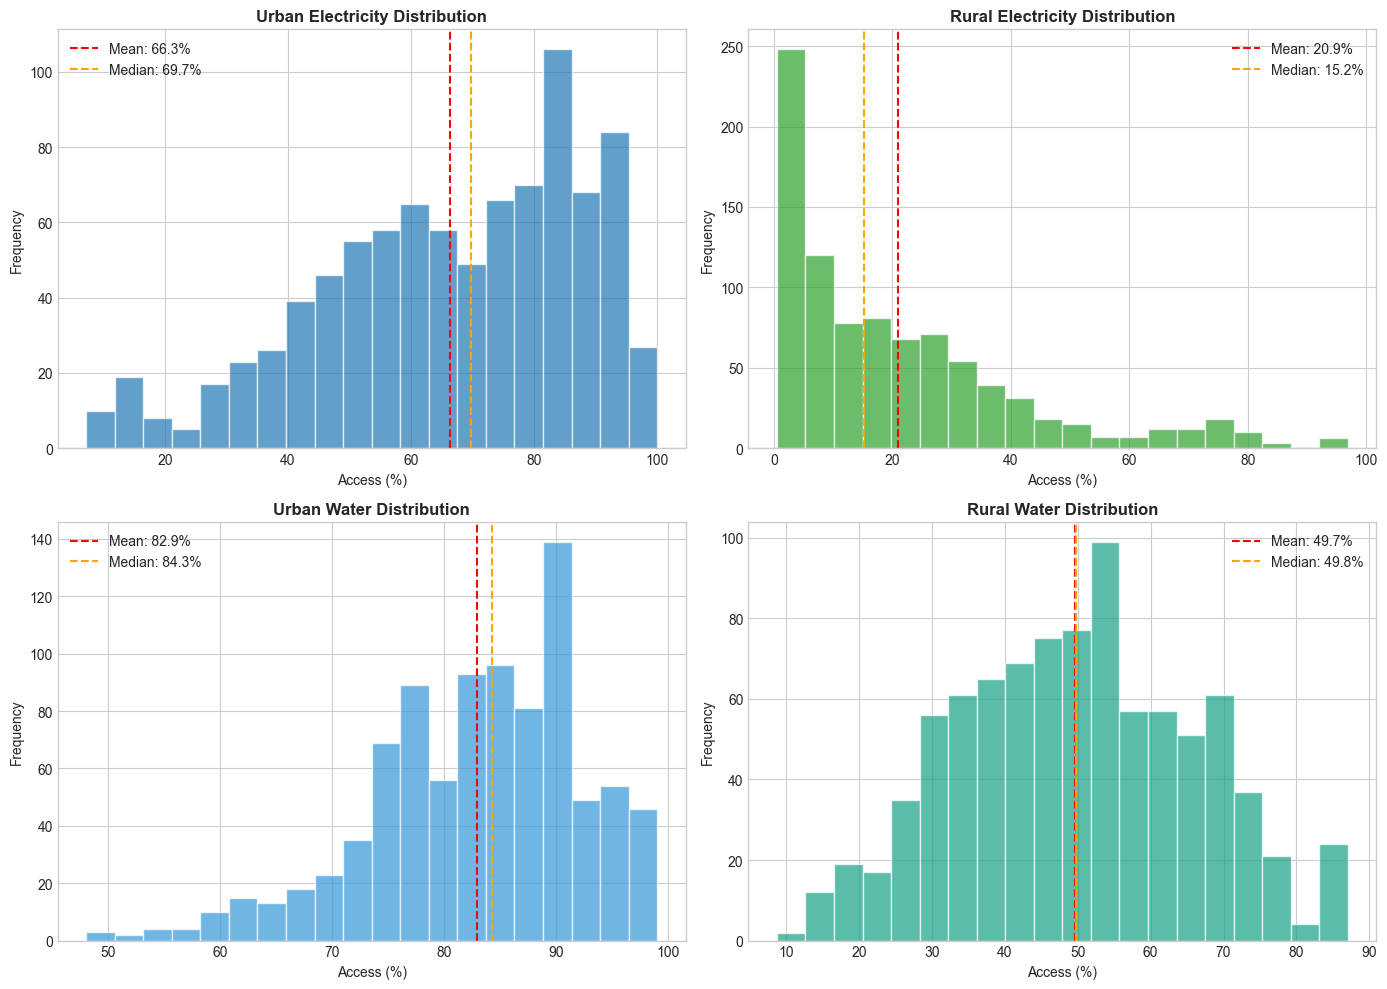

In [12]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

indicators = [('Urban_Elec', 'Urban Electricity', '#1f77b4'),
              ('Rural_Elec', 'Rural Electricity', '#2ca02c'),
              ('Urban_Water', 'Urban Water', '#3498db'),
              ('Rural_Water', 'Rural Water', '#16a085')]

for ax, (col, title, color) in zip(axes.flat, indicators):
    data = df_complete[col].dropna()
    ax.hist(data, bins=20, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.1f}%')
    ax.axvline(data.median(), color='orange', linestyle='--', label=f'Median: {data.median():.1f}%')
    ax.set_xlabel('Access (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{title} Distribution', fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.savefig('../csv/cross_ref_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 3. Correlation Analysis <a id='3-correlation'></a>

### Plain Language: What is Correlation?
Correlation measures how strongly two things are related:
- **r = 1.0**: Perfect positive (when one goes up, other always goes up)
- **r = 0.7-0.9**: Strong positive relationship
- **r = 0.4-0.6**: Moderate relationship
- **r = 0**: No relationship
- **r = -1.0**: Perfect negative (when one goes up, other goes down)

**Note:** Correlation does NOT mean causation!

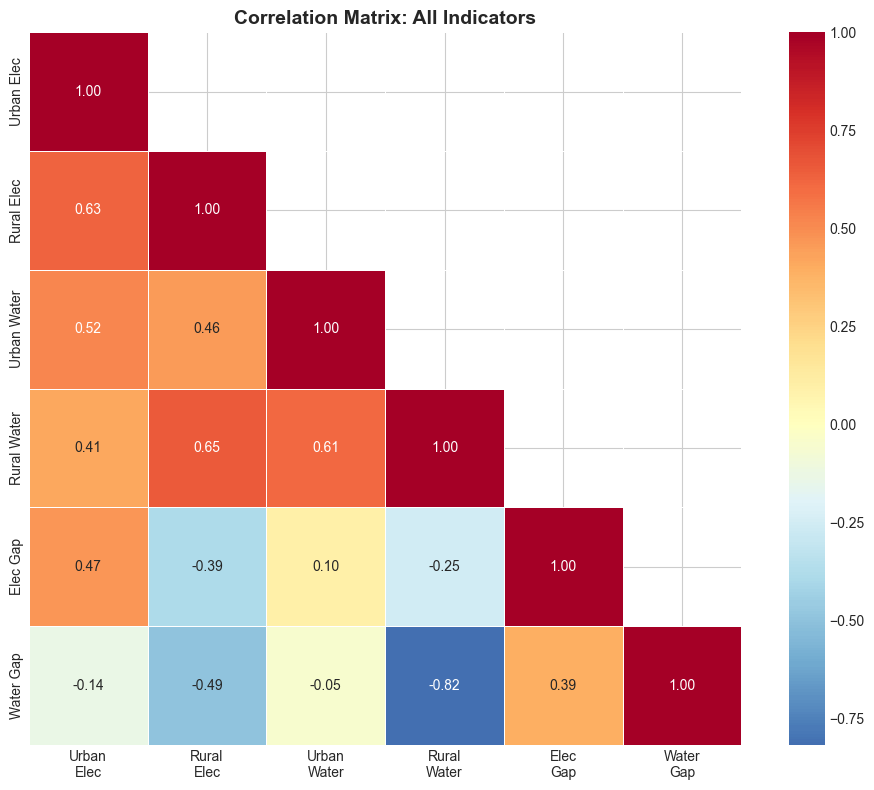


--- Correlation Matrix ---
             Urban_Elec  Rural_Elec  Urban_Water  Rural_Water  Elec_Gap  \
Urban_Elec        1.000       0.627        0.521        0.411     0.473   
Rural_Elec        0.627       1.000        0.458        0.653    -0.390   
Urban_Water       0.521       0.458        1.000        0.613     0.098   
Rural_Water       0.411       0.653        0.613        1.000    -0.252   
Elec_Gap          0.473      -0.390        0.098       -0.252     1.000   
Water_Gap        -0.140      -0.492       -0.045       -0.817     0.391   

             Water_Gap  
Urban_Elec      -0.140  
Rural_Elec      -0.492  
Urban_Water     -0.045  
Rural_Water     -0.817  
Elec_Gap         0.391  
Water_Gap        1.000  


In [13]:
# Correlation matrix
corr_cols = ['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water', 'Elec_Gap', 'Water_Gap']
corr_matrix = df_complete[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, mask=mask,
            xticklabels=['Urban\nElec', 'Rural\nElec', 'Urban\nWater', 'Rural\nWater', 'Elec\nGap', 'Water\nGap'],
            yticklabels=['Urban Elec', 'Rural Elec', 'Urban Water', 'Rural Water', 'Elec Gap', 'Water Gap'])
ax.set_title('Correlation Matrix: All Indicators', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('../csv/cross_ref_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n--- Correlation Matrix ---")
print(corr_matrix.round(3))

In [14]:
# Statistical significance of key correlations
print("=" * 70)
print("CORRELATION SIGNIFICANCE TESTS")
print("=" * 70)

pairs = [
    ('Urban_Elec', 'Urban_Water', 'Urban Electricity vs Urban Water'),
    ('Rural_Elec', 'Rural_Water', 'Rural Electricity vs Rural Water'),
    ('Urban_Elec', 'Rural_Elec', 'Urban vs Rural Electricity'),
    ('Urban_Water', 'Rural_Water', 'Urban vs Rural Water'),
    ('Elec_Gap', 'Water_Gap', 'Electricity Gap vs Water Gap'),
    ('Total_Elec', 'Total_Water', 'Total Electricity vs Total Water'),
]

print(f"\n{'Comparison':<45} {'r':>8} {'p-value':>12} {'Sig':>5}")
print("-" * 75)

for col1, col2, name in pairs:
    valid = df_complete[[col1, col2]].dropna()
    r, p = stats.pearsonr(valid[col1], valid[col2])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    print(f"{name:<45} {r:>8.3f} {p:>12.6f} {sig:>5}")

print("\n* p<0.05, ** p<0.01, *** p<0.001")

CORRELATION SIGNIFICANCE TESTS

Comparison                                           r      p-value   Sig
---------------------------------------------------------------------------
Urban Electricity vs Urban Water                 0.521     0.000000   ***
Rural Electricity vs Rural Water                 0.653     0.000000   ***
Urban vs Rural Electricity                       0.627     0.000000   ***
Urban vs Rural Water                             0.613     0.000000   ***
Electricity Gap vs Water Gap                     0.391     0.000000   ***
Total Electricity vs Total Water                 0.631     0.000000   ***

* p<0.05, ** p<0.01, *** p<0.001


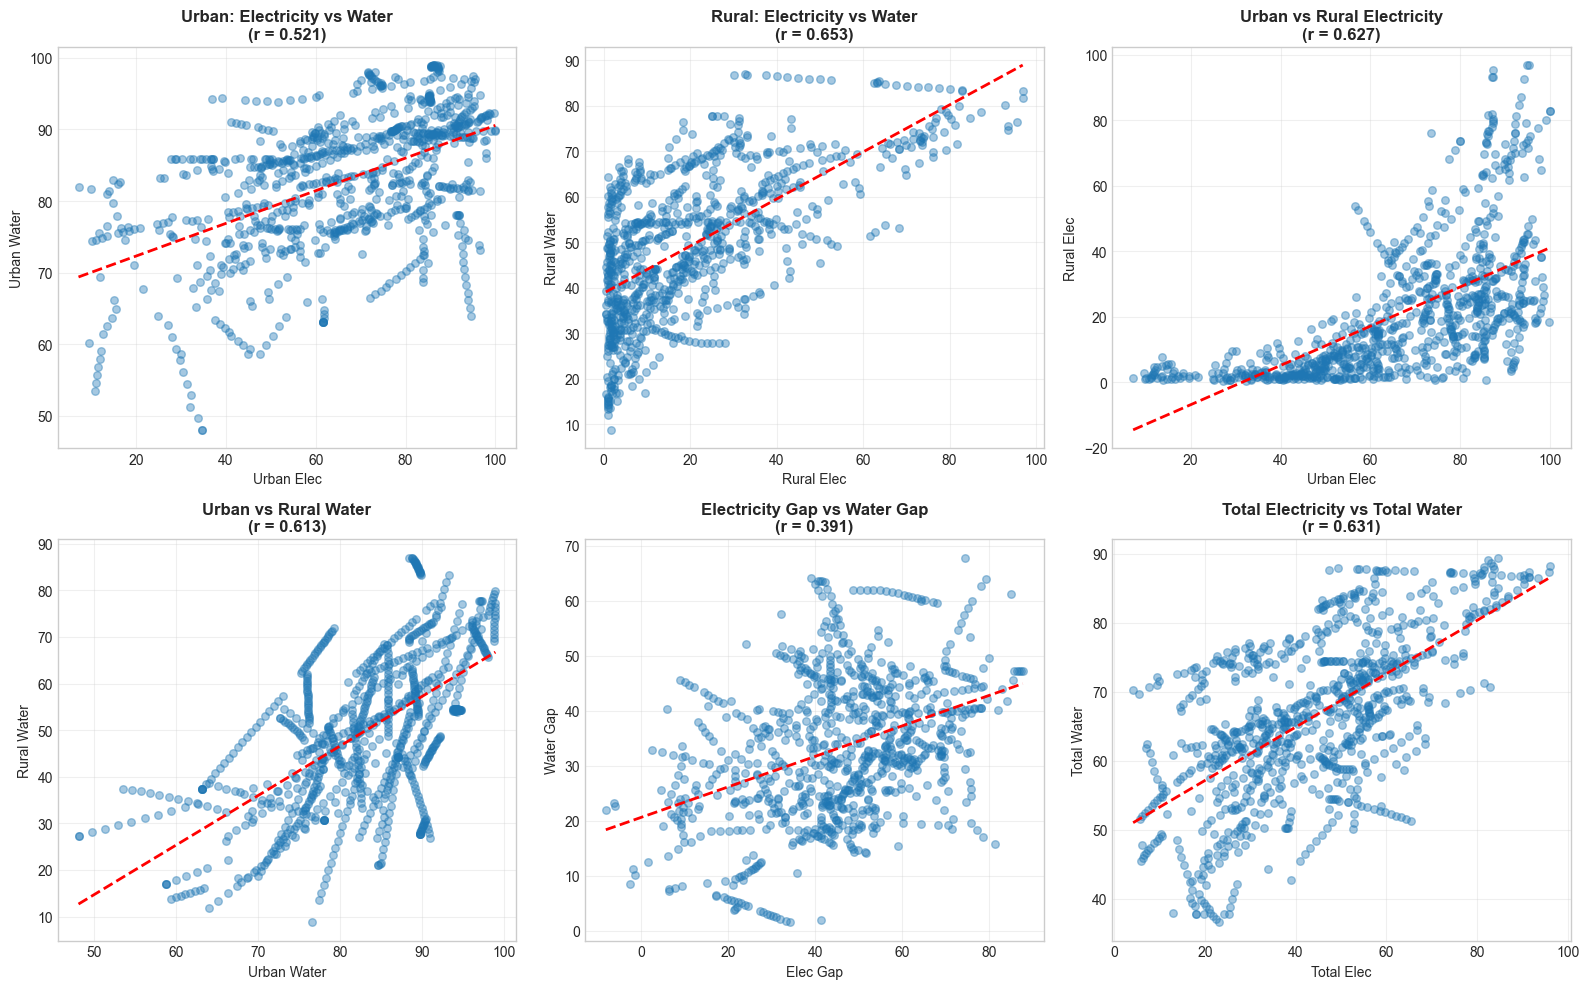

In [15]:
# Scatter plots of key relationships
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plots = [
    ('Urban_Elec', 'Urban_Water', 'Urban: Electricity vs Water'),
    ('Rural_Elec', 'Rural_Water', 'Rural: Electricity vs Water'),
    ('Urban_Elec', 'Rural_Elec', 'Urban vs Rural Electricity'),
    ('Urban_Water', 'Rural_Water', 'Urban vs Rural Water'),
    ('Elec_Gap', 'Water_Gap', 'Electricity Gap vs Water Gap'),
    ('Total_Elec', 'Total_Water', 'Total Electricity vs Total Water'),
]

for ax, (x, y, title) in zip(axes.flat, plots):
    valid = df_complete[[x, y]].dropna()
    ax.scatter(valid[x], valid[y], alpha=0.4, s=30)
    
    # Add trend line
    z = np.polyfit(valid[x], valid[y], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid[x].min(), valid[x].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2)
    
    r, _ = stats.pearsonr(valid[x], valid[y])
    ax.set_xlabel(x.replace('_', ' '))
    ax.set_ylabel(y.replace('_', ' '))
    ax.set_title(f'{title}\n(r = {r:.3f})', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../csv/cross_ref_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 4. Outlier Detection <a id='4-outliers'></a>

### Methods Used:
1. **Z-Score**: Values more than 2.5 standard deviations from mean
2. **IQR Method**: Values below Q1-1.5*IQR or above Q3+1.5*IQR
3. **Domain-specific**: Unusual patterns (e.g., Rural > Urban)

In [16]:
# Z-Score outliers
print("=" * 60)
print("OUTLIER DETECTION - Z-SCORE METHOD (|z| > 2.5)")
print("=" * 60)

for col in ['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']:
    valid_idx = df_complete[col].notna()
    z_scores = np.abs(zscore(df_complete.loc[valid_idx, col]))
    outliers = df_complete.loc[valid_idx][z_scores > 2.5]
    print(f"\n{col}: {len(outliers)} outliers")
    if len(outliers) > 0:
        print(outliers[['Country', 'Year', col]].head(10))

OUTLIER DETECTION - Z-SCORE METHOD (|z| > 2.5)

Urban_Elec: 15 outliers
                       Country  Year  Urban_Elec
183   Central African Republic  2008        11.9
200                       Chad  2000        10.1
201                       Chad  2001        11.2
202                       Chad  2002        12.4
554              Guinea-Bissau  2010        11.8
629                    Liberia  2010         9.9
630                    Liberia  2011         7.2
1055               South Sudan  2011        10.8
1056               South Sudan  2012        11.1
1057               South Sudan  2013        11.3

Rural_Elec: 39 outliers
        Country  Year  Rural_Elec
139  Cabo Verde  2014        73.8
140  Cabo Verde  2015        76.2
141  Cabo Verde  2016        78.8
142  Cabo Verde  2017        81.2
143  Cabo Verde  2018        84.6
144  Cabo Verde  2019        87.3
145  Cabo Verde  2020        92.7
146  Cabo Verde  2021        96.9
147  Cabo Verde  2022        96.9
242     Comoros  2017   

In [17]:
# IQR outlier detection
print("=" * 60)
print("OUTLIER DETECTION - IQR METHOD")
print("=" * 60)

def find_iqr_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers, lower, upper

for col in ['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water', 'Elec_Gap', 'Water_Gap']:
    outliers, lower, upper = find_iqr_outliers(df_complete, col)
    print(f"\n{col}: {len(outliers)} outliers (bounds: {lower:.1f} - {upper:.1f})")

OUTLIER DETECTION - IQR METHOD

Urban_Elec: 0 outliers (bounds: 1.7 - 134.7)

Rural_Elec: 44 outliers (bounds: -34.4 - 69.8)

Urban_Water: 11 outliers (bounds: 57.4 - 109.0)

Rural_Water: 0 outliers (bounds: 1.2 - 97.7)

Elec_Gap: 6 outliers (bounds: -0.1 - 92.1)

Water_Gap: 0 outliers (bounds: -4.6 - 71.1)


In [18]:
# Domain-specific outliers: Rural > Urban (unusual pattern)
print("=" * 60)
print("UNUSUAL PATTERNS: Rural Access > Urban Access")
print("=" * 60)

# Electricity: Rural > Urban
unusual_elec = df_complete[df_complete['Rural_Elec'] > df_complete['Urban_Elec']]
print(f"\nElectricity (Rural > Urban): {len(unusual_elec)} cases")
if len(unusual_elec) > 0:
    print(unusual_elec[['Country', 'Year', 'Rural_Elec', 'Urban_Elec']].head(10))

# Water: Rural > Urban
unusual_water = df_complete[df_complete['Rural_Water'] > df_complete['Urban_Water']]
print(f"\nWater (Rural > Urban): {len(unusual_water)} cases")
if len(unusual_water) > 0:
    print(unusual_water[['Country', 'Year', 'Rural_Water', 'Urban_Water']].head(10))

UNUSUAL PATTERNS: Rural Access > Urban Access

Electricity (Rural > Urban): 6 cases
                    Country  Year  Rural_Elec  Urban_Elec
146              Cabo Verde  2021        96.9        94.9
147              Cabo Verde  2022        96.9        95.3
911   Sao Tome and Principe  2017        76.2        73.5
1039           South Africa  2020        95.5        87.3
1040           South Africa  2021        93.4        87.4
1041           South Africa  2022        93.4        87.1

Water (Rural > Urban): 0 cases


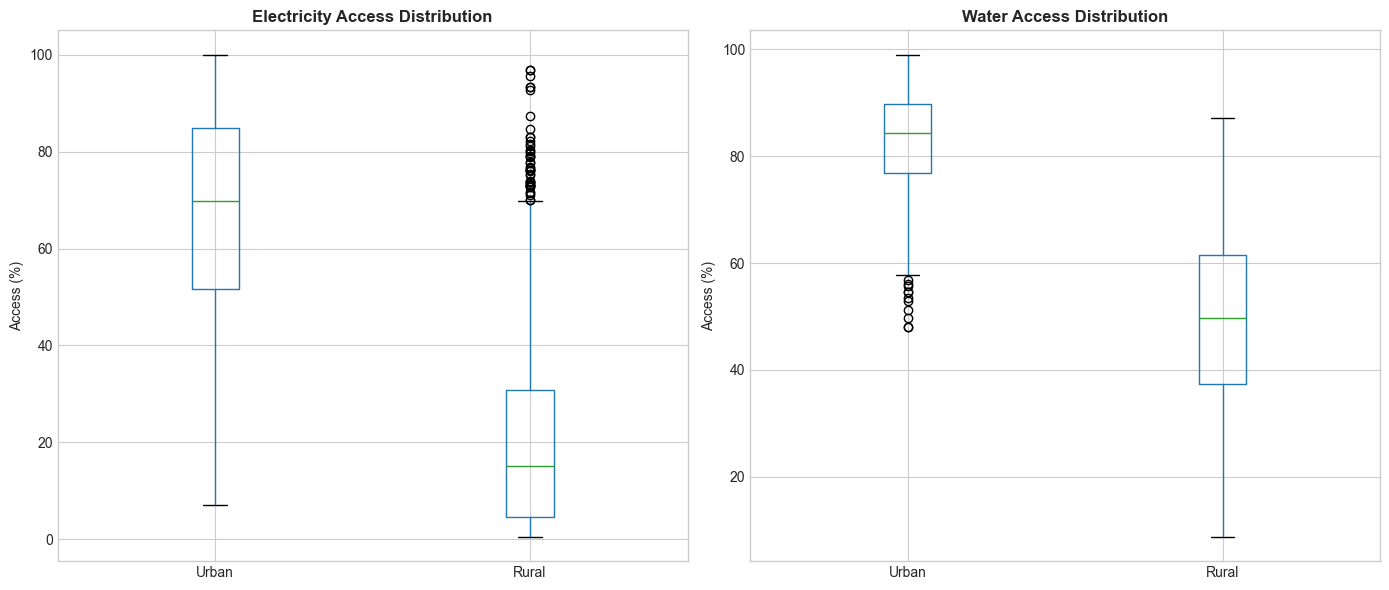

In [19]:
# Box plots to visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Electricity
ax1 = axes[0]
df_complete[['Urban_Elec', 'Rural_Elec']].boxplot(ax=ax1)
ax1.set_title('Electricity Access Distribution', fontweight='bold')
ax1.set_ylabel('Access (%)')
ax1.set_xticklabels(['Urban', 'Rural'])

# Water
ax2 = axes[1]
df_complete[['Urban_Water', 'Rural_Water']].boxplot(ax=ax2)
ax2.set_title('Water Access Distribution', fontweight='bold')
ax2.set_ylabel('Access (%)')
ax2.set_xticklabels(['Urban', 'Rural'])

plt.tight_layout()
plt.savefig('../csv/cross_ref_outlier_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 5. Pattern Analysis <a id='5-patterns'></a>

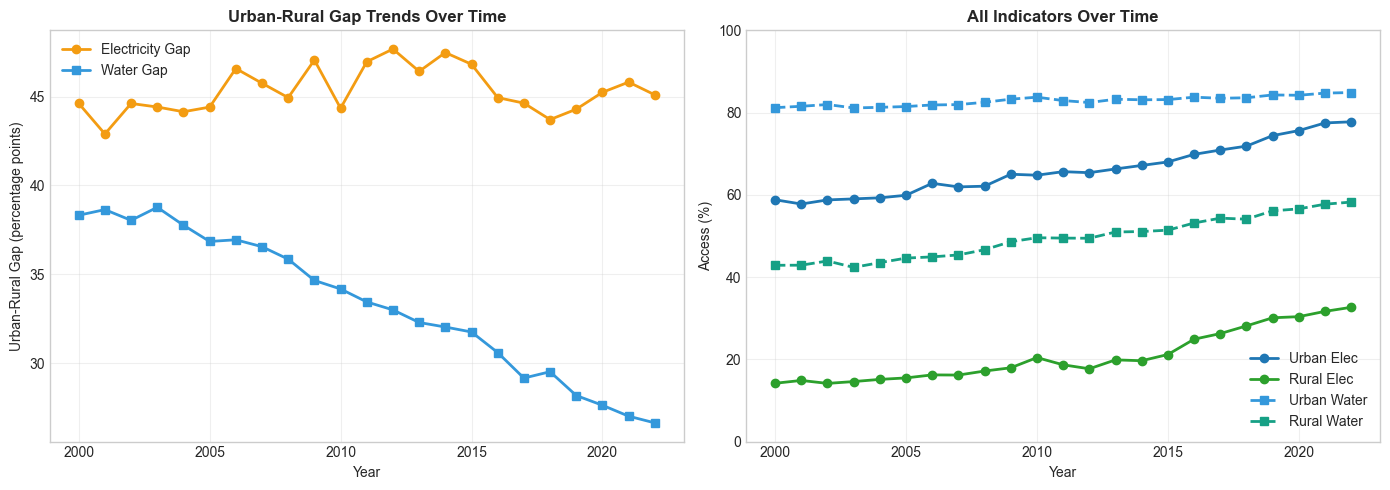

In [20]:
# Pattern 1: Urban-Rural Gap Over Time
gap_by_year = df_complete.groupby('Year').agg({
    'Elec_Gap': 'mean',
    'Water_Gap': 'mean',
    'Urban_Elec': 'mean',
    'Rural_Elec': 'mean',
    'Urban_Water': 'mean',
    'Rural_Water': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gap trends
ax1 = axes[0]
ax1.plot(gap_by_year['Year'], gap_by_year['Elec_Gap'], marker='o', label='Electricity Gap', color='#f39c12', linewidth=2)
ax1.plot(gap_by_year['Year'], gap_by_year['Water_Gap'], marker='s', label='Water Gap', color='#3498db', linewidth=2)
ax1.set_xlabel('Year')
ax1.set_ylabel('Urban-Rural Gap (percentage points)')
ax1.set_title('Urban-Rural Gap Trends Over Time', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# All four indicators
ax2 = axes[1]
ax2.plot(gap_by_year['Year'], gap_by_year['Urban_Elec'], marker='o', label='Urban Elec', color='#1f77b4', linewidth=2)
ax2.plot(gap_by_year['Year'], gap_by_year['Rural_Elec'], marker='o', label='Rural Elec', color='#2ca02c', linewidth=2)
ax2.plot(gap_by_year['Year'], gap_by_year['Urban_Water'], marker='s', label='Urban Water', color='#3498db', linewidth=2, linestyle='--')
ax2.plot(gap_by_year['Year'], gap_by_year['Rural_Water'], marker='s', label='Rural Water', color='#16a085', linewidth=2, linestyle='--')
ax2.set_xlabel('Year')
ax2.set_ylabel('Access (%)')
ax2.set_title('All Indicators Over Time', fontweight='bold')
ax2.legend()
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../csv/cross_ref_gap_trends.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Pattern 2: Country Clusters - High/Low performers across all indicators
latest_year = df_complete['Year'].max()
df_latest = df_complete[df_complete['Year'] == latest_year].copy()

# Calculate average across all 4 indicators
df_latest['Overall_Avg'] = df_latest[['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']].mean(axis=1)
df_latest['Avg_Gap'] = (df_latest['Elec_Gap'] + df_latest['Water_Gap']) / 2

# Categorize countries
df_latest['Category'] = pd.cut(df_latest['Overall_Avg'], 
                                bins=[0, 40, 60, 80, 100], 
                                labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

print("=" * 60)
print(f"COUNTRY PERFORMANCE CATEGORIES ({latest_year})")
print("=" * 60)
print(df_latest['Category'].value_counts().sort_index())

COUNTRY PERFORMANCE CATEGORIES (2022)
Category
Low             3
Medium-Low     11
Medium-High    22
High            5
Name: count, dtype: int64


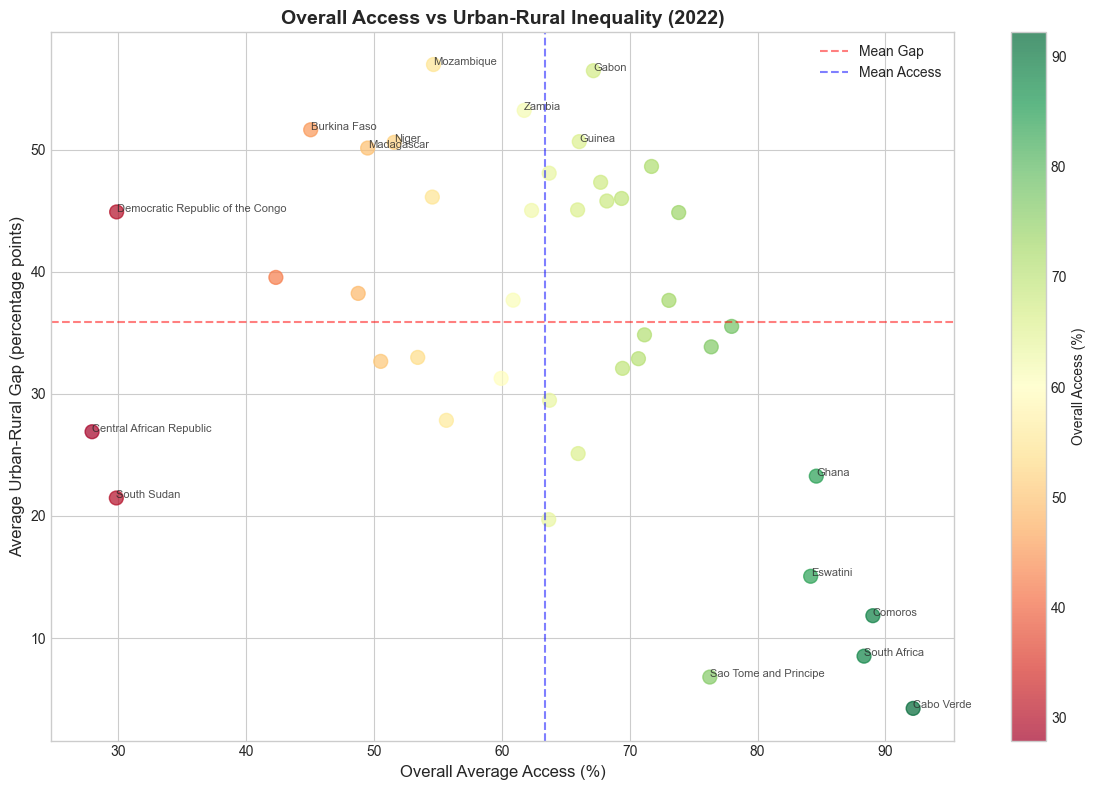

In [22]:
# Scatter: Overall Access vs Inequality (Gap)
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df_latest['Overall_Avg'], df_latest['Avg_Gap'], 
                     c=df_latest['Overall_Avg'], cmap='RdYlGn', s=100, alpha=0.7)

# Add country labels for notable points
for idx, row in df_latest.iterrows():
    if row['Overall_Avg'] > 80 or row['Overall_Avg'] < 40 or row['Avg_Gap'] > 50 or row['Avg_Gap'] < 10:
        ax.annotate(row['Country'], (row['Overall_Avg'], row['Avg_Gap']), 
                    fontsize=8, alpha=0.8)

ax.set_xlabel('Overall Average Access (%)', fontsize=12)
ax.set_ylabel('Average Urban-Rural Gap (percentage points)', fontsize=12)
ax.set_title(f'Overall Access vs Urban-Rural Inequality ({latest_year})', fontweight='bold', fontsize=14)
ax.axhline(y=df_latest['Avg_Gap'].mean(), color='red', linestyle='--', alpha=0.5, label='Mean Gap')
ax.axvline(x=df_latest['Overall_Avg'].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean Access')
ax.legend()
plt.colorbar(scatter, label='Overall Access (%)')

plt.tight_layout()
plt.savefig('../csv/cross_ref_access_vs_gap.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Pattern 3: Electricity-Water relationship by development level
# Countries where electricity leads water vs water leads electricity

df_latest['Elec_Leads'] = df_latest['Total_Elec'] > df_latest['Total_Water']

print("=" * 60)
print("ELECTRICITY vs WATER - WHICH LEADS?")
print("=" * 60)
print(f"\nCountries where Electricity > Water: {df_latest['Elec_Leads'].sum()}")
print(f"Countries where Water > Electricity: {(~df_latest['Elec_Leads']).sum()}")

print("\nCountries where Electricity leads (Total Elec > Total Water):")
elec_leads = df_latest[df_latest['Elec_Leads']][['Country', 'Total_Elec', 'Total_Water']].sort_values('Total_Elec', ascending=False)
print(elec_leads.head(10))

print("\nCountries where Water leads (Total Water > Total Elec):")
water_leads = df_latest[~df_latest['Elec_Leads']][['Country', 'Total_Elec', 'Total_Water']].sort_values('Total_Water', ascending=False)
print(water_leads.head(10))

ELECTRICITY vs WATER - WHICH LEADS?

Countries where Electricity > Water: 7
Countries where Water > Electricity: 34

Countries where Electricity leads (Total Elec > Total Water):
                    Country  Total_Elec  Total_Water
147              Cabo Verde       96.10    88.238960
247                 Comoros       91.45    86.584953
1041           South Africa       90.25    86.403184
591                   Kenya       81.50    71.248751
916   Sao Tome and Principe       76.85    75.672923
441                Ethiopia       68.50    63.339209
1091                  Sudan       66.70    65.225492

Countries where Water leads (Total Water > Total Elec):
      Country  Total_Elec  Total_Water
72   Botswana       60.25    87.407276
941   Senegal       70.00    85.942689
516     Ghana       83.30    85.885786
816   Namibia       54.00    84.869128
416  Eswatini       83.85    84.454641
716      Mali       59.00    84.402546
491    Gambia       57.00    84.360868
616   Lesotho       60.65   

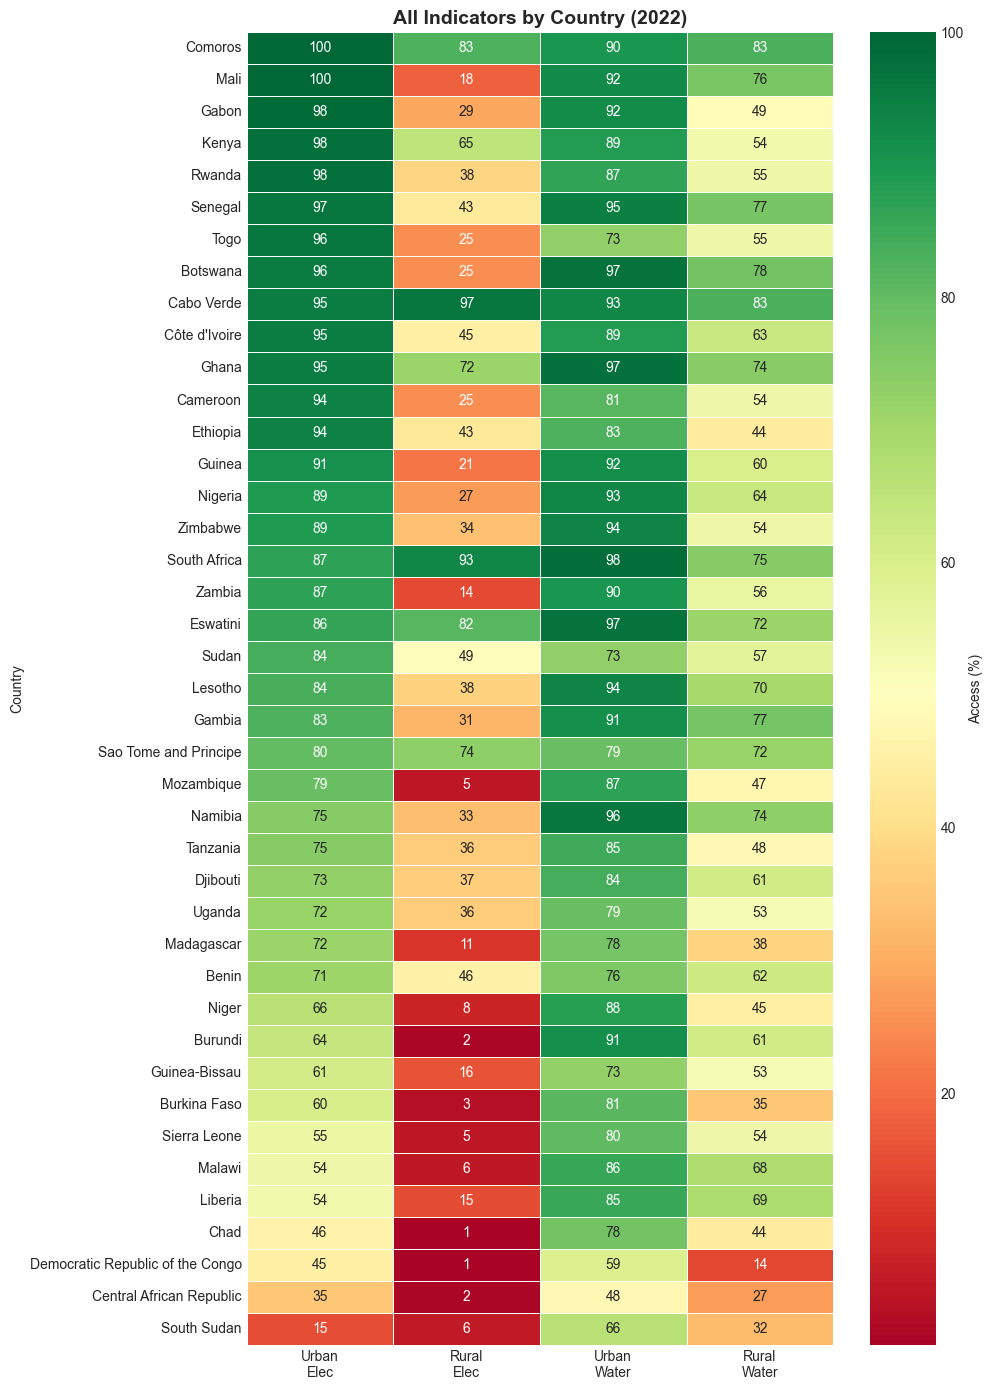

In [24]:
# Heatmap: All 4 indicators by country
heatmap_data = df_latest[['Country', 'Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']].set_index('Country')
heatmap_data = heatmap_data.sort_values('Urban_Elec', ascending=False)

fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdYlGn', center=50,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Access (%)'},
            xticklabels=['Urban\nElec', 'Rural\nElec', 'Urban\nWater', 'Rural\nWater'])
ax.set_title(f'All Indicators by Country ({latest_year})', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('../csv/cross_ref_country_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 6. Noteworthy Data Points <a id='6-noteworthy'></a>

In [25]:
print("=" * 70)
print("NOTEWORTHY DATA POINTS")
print("=" * 70)

# 1. Highest overall performers
print("\n1. TOP 5 OVERALL PERFORMERS (All 4 indicators average):")
top5 = df_latest.nlargest(5, 'Overall_Avg')[['Country', 'Overall_Avg', 'Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']]
print(top5.to_string(index=False))

# 2. Lowest overall performers
print("\n2. BOTTOM 5 OVERALL PERFORMERS:")
bottom5 = df_latest.nsmallest(5, 'Overall_Avg')[['Country', 'Overall_Avg', 'Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']]
print(bottom5.to_string(index=False))

# 3. Largest urban-rural gaps
print("\n3. LARGEST URBAN-RURAL GAPS (Average of Elec + Water gaps):")
largest_gap = df_latest.nlargest(5, 'Avg_Gap')[['Country', 'Avg_Gap', 'Elec_Gap', 'Water_Gap']]
print(largest_gap.to_string(index=False))

# 4. Smallest urban-rural gaps (most equal)
print("\n4. SMALLEST URBAN-RURAL GAPS (Most Equal):")
smallest_gap = df_latest.nsmallest(5, 'Avg_Gap')[['Country', 'Avg_Gap', 'Elec_Gap', 'Water_Gap']]
print(smallest_gap.to_string(index=False))

NOTEWORTHY DATA POINTS

1. TOP 5 OVERALL PERFORMERS (All 4 indicators average):
     Country  Overall_Avg  Urban_Elec  Rural_Elec  Urban_Water  Rural_Water
  Cabo Verde    92.169480        95.3        96.9    93.283029    83.194890
     Comoros    89.017476       100.0        82.9    89.869152    83.300753
South Africa    88.326592        87.1        93.4    98.073081    74.733287
       Ghana    84.592893        95.0        71.6    97.445657    74.325914
    Eswatini    84.152320        86.1        81.6    97.265485    71.643797

2. BOTTOM 5 OVERALL PERFORMERS:
                         Country  Overall_Avg  Urban_Elec  Rural_Elec  Urban_Water  Rural_Water
        Central African Republic    27.934301        34.7         1.6    48.064237    27.372969
                     South Sudan    29.833731        15.0         5.7    66.138880    32.496044
Democratic Republic of the Congo    29.858029        45.3         1.0    59.308896    13.823221
                            Chad    42.314701  

In [26]:
# 5. Biggest improvers over time
first_year = df_complete['Year'].min()
df_first = df_complete[df_complete['Year'] == first_year].set_index('Country')
df_last = df_latest.set_index('Country')

# Calculate improvement
common_countries = df_first.index.intersection(df_last.index)
improvement = pd.DataFrame(index=common_countries)

for col in ['Urban_Elec', 'Rural_Elec', 'Urban_Water', 'Rural_Water']:
    improvement[f'{col}_Change'] = df_last.loc[common_countries, col] - df_first.loc[common_countries, col]

improvement['Total_Change'] = improvement.mean(axis=1)

print("\n5. BIGGEST IMPROVERS (Average change across all 4 indicators):")
print(improvement.nlargest(10, 'Total_Change')[['Total_Change']].round(1))

print("\n6. LEAST IMPROVEMENT / DECLINE:")
print(improvement.nsmallest(5, 'Total_Change')[['Total_Change']].round(1))


5. BIGGEST IMPROVERS (Average change across all 4 indicators):
            Total_Change
Country                 
Eswatini            35.4
Kenya               32.0
Lesotho             31.9
Tanzania            31.0
Ghana               27.2
Uganda              27.1
Ethiopia            25.1
Cabo Verde          24.4
Sudan               24.3
Botswana            23.9

6. LEAST IMPROVEMENT / DECLINE:
              Total_Change
Country                   
Burkina Faso           2.1
Djibouti               3.3
Namibia                5.4
Zimbabwe               7.3
Gabon                  8.6


---
# 7. Population Impact Analysis <a id='7-population'></a>

### Plain Language: Why This Matters

Percentages don't tell the whole story. A country with 50% electricity access and 10 million people has **5 million without electricity**. A country with 50% access but 200 million people has **100 million without electricity**.

This section converts percentages to **absolute numbers of people** to show the real human impact.

In [27]:
# Calculate absolute numbers of people WITH and WITHOUT access
df_pop = df_merged.copy()

# Calculate people WITH access
df_pop['Urban_With_Elec'] = (df_pop['Urban_Elec'] / 100) * df_pop['Urban_Pop']
df_pop['Rural_With_Elec'] = (df_pop['Rural_Elec'] / 100) * df_pop['Rural_Pop']
df_pop['Urban_With_Water'] = (df_pop['Urban_Water'] / 100) * df_pop['Urban_Pop']
df_pop['Rural_With_Water'] = (df_pop['Rural_Water'] / 100) * df_pop['Rural_Pop']

# Calculate people WITHOUT access
df_pop['Urban_Without_Elec'] = df_pop['Urban_Pop'] - df_pop['Urban_With_Elec']
df_pop['Rural_Without_Elec'] = df_pop['Rural_Pop'] - df_pop['Rural_With_Elec']
df_pop['Urban_Without_Water'] = df_pop['Urban_Pop'] - df_pop['Urban_With_Water']
df_pop['Rural_Without_Water'] = df_pop['Rural_Pop'] - df_pop['Rural_With_Water']

# Total without access
df_pop['Total_Without_Elec'] = df_pop['Urban_Without_Elec'] + df_pop['Rural_Without_Elec']
df_pop['Total_Without_Water'] = df_pop['Urban_Without_Water'] + df_pop['Rural_Without_Water']
df_pop['Total_Pop'] = df_pop['Urban_Pop'] + df_pop['Rural_Pop']

print("Population impact columns created!")

Population impact columns created!


In [28]:
# SSA-wide totals for latest year
latest_year = df_pop['Year'].max()
# Filter to rows with both population and access data
df_pop_latest = df_pop[df_pop['Year'] == latest_year].dropna(subset=['Total_Pop', 'Urban_Elec', 'Rural_Elec'])

print("=" * 70)
print(f"SSA POPULATION IMPACT SUMMARY ({latest_year})")
print("=" * 70)

# Totals
total_pop = df_pop_latest['Total_Pop'].sum()
total_urban = df_pop_latest['Urban_Pop'].sum()
total_rural = df_pop_latest['Rural_Pop'].sum()

print(f"\n--- TOTAL POPULATION ---")
print(f"Total SSA Population: {total_pop/1e6:,.0f} million")
print(f"Urban Population: {total_urban/1e6:,.0f} million ({total_urban/total_pop*100:.1f}%)")
print(f"Rural Population: {total_rural/1e6:,.0f} million ({total_rural/total_pop*100:.1f}%)")

# Without electricity - filter for rows with electricity data
df_elec = df_pop_latest.dropna(subset=['Urban_Without_Elec', 'Rural_Without_Elec'])
urban_no_elec = df_elec['Urban_Without_Elec'].sum()
rural_no_elec = df_elec['Rural_Without_Elec'].sum()
total_no_elec = urban_no_elec + rural_no_elec
pop_with_elec_data = df_elec['Total_Pop'].sum()

print(f"\n--- PEOPLE WITHOUT ELECTRICITY ---")
print(f"Urban without electricity: {urban_no_elec/1e6:,.0f} million")
print(f"Rural without electricity: {rural_no_elec/1e6:,.0f} million")
print(f"TOTAL without electricity: {total_no_elec/1e6:,.0f} million ({total_no_elec/pop_with_elec_data*100:.1f}%)")
print(f"(Based on {len(df_elec)} countries with complete electricity data)")

# Without water - filter for rows with water data
df_water = df_pop_latest.dropna(subset=['Urban_Without_Water', 'Rural_Without_Water'])
urban_no_water = df_water['Urban_Without_Water'].sum()
rural_no_water = df_water['Rural_Without_Water'].sum()
total_no_water = urban_no_water + rural_no_water
pop_with_water_data = df_water['Total_Pop'].sum()

print(f"\n--- PEOPLE WITHOUT BASIC WATER ---")
print(f"Urban without water: {urban_no_water/1e6:,.0f} million")
print(f"Rural without water: {rural_no_water/1e6:,.0f} million")
print(f"TOTAL without water: {total_no_water/1e6:,.0f} million ({total_no_water/pop_with_water_data*100:.1f}%)")
print(f"(Based on {len(df_water)} countries with complete water data)")

SSA POPULATION IMPACT SUMMARY (2024)

--- TOTAL POPULATION ---
Total SSA Population: 0 million
Urban Population: 0 million (nan%)
Rural Population: 0 million (nan%)

--- PEOPLE WITHOUT ELECTRICITY ---
Urban without electricity: 0 million
Rural without electricity: 0 million
TOTAL without electricity: 0 million (nan%)
(Based on 0 countries with complete electricity data)

--- PEOPLE WITHOUT BASIC WATER ---
Urban without water: 0 million
Rural without water: 0 million
TOTAL without water: 0 million (nan%)
(Based on 0 countries with complete water data)


In [29]:
# Countries with MOST people without electricity
print("=" * 70)
print("COUNTRIES WITH MOST PEOPLE WITHOUT ELECTRICITY")
print("=" * 70)

# Filter to countries with complete electricity data
df_elec_complete = df_pop_latest.dropna(subset=['Total_Without_Elec', 'Rural_Without_Elec', 'Urban_Without_Elec'])

top_no_elec = df_elec_complete.nlargest(15, 'Total_Without_Elec')[
    ['Country', 'Total_Pop', 'Total_Without_Elec', 'Rural_Without_Elec', 'Urban_Without_Elec']
].copy()
top_no_elec['Total_Pop_M'] = top_no_elec['Total_Pop'] / 1e6
top_no_elec['Without_Elec_M'] = top_no_elec['Total_Without_Elec'] / 1e6
top_no_elec['Rural_NoElec_M'] = top_no_elec['Rural_Without_Elec'] / 1e6
top_no_elec['Urban_NoElec_M'] = top_no_elec['Urban_Without_Elec'] / 1e6
top_no_elec['Pct_Without'] = (top_no_elec['Total_Without_Elec'] / top_no_elec['Total_Pop'] * 100)

print(f"\n{'Country':<30} {'Pop (M)':>10} {'No Elec (M)':>12} {'Rural':>10} {'Urban':>10} {'% Without':>10}")
print("-" * 85)
for _, row in top_no_elec.iterrows():
    print(f"{row['Country']:<30} {row['Total_Pop_M']:>10.1f} {row['Without_Elec_M']:>12.1f} {row['Rural_NoElec_M']:>10.1f} {row['Urban_NoElec_M']:>10.1f} {row['Pct_Without']:>10.1f}%")

COUNTRIES WITH MOST PEOPLE WITHOUT ELECTRICITY

Country                           Pop (M)  No Elec (M)      Rural      Urban  % Without
-------------------------------------------------------------------------------------


In [30]:
# Countries with MOST people without water
print("=" * 70)
print("COUNTRIES WITH MOST PEOPLE WITHOUT BASIC WATER")
print("=" * 70)

# Filter to countries with complete water data
df_water_complete = df_pop_latest.dropna(subset=['Total_Without_Water', 'Rural_Without_Water', 'Urban_Without_Water'])

top_no_water = df_water_complete.nlargest(15, 'Total_Without_Water')[
    ['Country', 'Total_Pop', 'Total_Without_Water', 'Rural_Without_Water', 'Urban_Without_Water']
].copy()
top_no_water['Total_Pop_M'] = top_no_water['Total_Pop'] / 1e6
top_no_water['Without_Water_M'] = top_no_water['Total_Without_Water'] / 1e6
top_no_water['Rural_NoWater_M'] = top_no_water['Rural_Without_Water'] / 1e6
top_no_water['Urban_NoWater_M'] = top_no_water['Urban_Without_Water'] / 1e6
top_no_water['Pct_Without'] = (top_no_water['Total_Without_Water'] / top_no_water['Total_Pop'] * 100)

print(f"\n{'Country':<30} {'Pop (M)':>10} {'No Water (M)':>12} {'Rural':>10} {'Urban':>10} {'% Without':>10}")
print("-" * 85)
for _, row in top_no_water.iterrows():
    print(f"{row['Country']:<30} {row['Total_Pop_M']:>10.1f} {row['Without_Water_M']:>12.1f} {row['Rural_NoWater_M']:>10.1f} {row['Urban_NoWater_M']:>10.1f} {row['Pct_Without']:>10.1f}%")

COUNTRIES WITH MOST PEOPLE WITHOUT BASIC WATER

Country                           Pop (M) No Water (M)      Rural      Urban  % Without
-------------------------------------------------------------------------------------


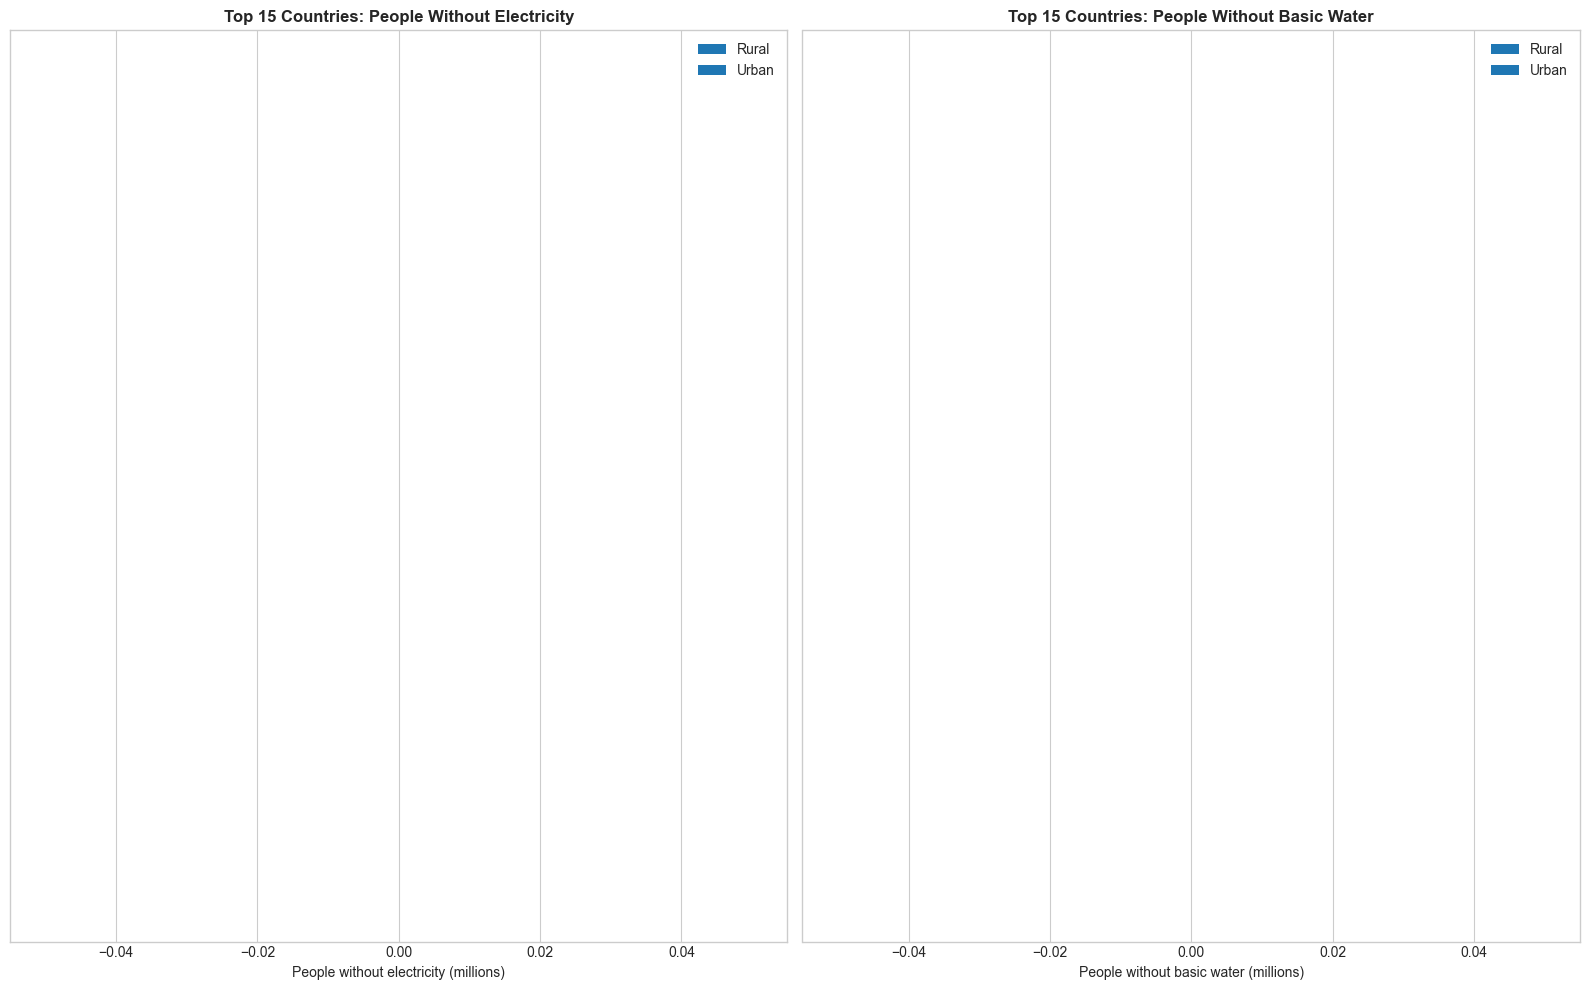

In [31]:
# Visualization: Population without access by country
# Filter to countries with complete data
df_pop_complete = df_pop_latest.dropna(subset=['Total_Without_Elec', 'Total_Without_Water', 
                                                'Rural_Without_Elec', 'Urban_Without_Elec',
                                                'Rural_Without_Water', 'Urban_Without_Water'])

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Electricity
ax1 = axes[0]
top15_elec = df_pop_complete.nlargest(15, 'Total_Without_Elec')
y_pos = range(len(top15_elec))
bars1 = ax1.barh(y_pos, top15_elec['Rural_Without_Elec']/1e6, label='Rural', color='#2ca02c', alpha=0.8)
bars2 = ax1.barh(y_pos, top15_elec['Urban_Without_Elec']/1e6, 
                 left=top15_elec['Rural_Without_Elec']/1e6, label='Urban', color='#1f77b4', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top15_elec['Country'])
ax1.set_xlabel('People without electricity (millions)')
ax1.set_title('Top 15 Countries: People Without Electricity', fontweight='bold')
ax1.legend()

# Add total labels
for i, (_, row) in enumerate(top15_elec.iterrows()):
    total = row['Total_Without_Elec']/1e6
    ax1.text(total + 1, i, f'{total:.1f}M', va='center', fontsize=9)

# Water
ax2 = axes[1]
top15_water = df_pop_complete.nlargest(15, 'Total_Without_Water')
y_pos = range(len(top15_water))
bars1 = ax2.barh(y_pos, top15_water['Rural_Without_Water']/1e6, label='Rural', color='#16a085', alpha=0.8)
bars2 = ax2.barh(y_pos, top15_water['Urban_Without_Water']/1e6, 
                 left=top15_water['Rural_Without_Water']/1e6, label='Urban', color='#3498db', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top15_water['Country'])
ax2.set_xlabel('People without basic water (millions)')
ax2.set_title('Top 15 Countries: People Without Basic Water', fontweight='bold')
ax2.legend()

# Add total labels
for i, (_, row) in enumerate(top15_water.iterrows()):
    total = row['Total_Without_Water']/1e6
    ax2.text(total + 1, i, f'{total:.1f}M', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../csv/population_without_access.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
# Summary visualization: SSA totals
# Filter to only countries with complete data for visualization
df_pop_viz = df_pop_latest.dropna(subset=['Urban_With_Elec', 'Rural_With_Elec', 'Urban_Without_Elec', 'Rural_Without_Elec',
                                          'Urban_With_Water', 'Rural_With_Water', 'Urban_Without_Water', 'Rural_Without_Water'])

print(f"Countries with complete data for visualization: {len(df_pop_viz)}")

if len(df_pop_viz) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Recalculate totals for visualization with complete data
    total_pop_viz = df_pop_viz['Total_Pop'].sum()
    total_urban_viz = df_pop_viz['Urban_Pop'].sum()
    total_rural_viz = df_pop_viz['Rural_Pop'].sum()

    # 1. Pie chart: Electricity access breakdown
    ax1 = axes[0, 0]
    urban_with_elec = max(0, df_pop_viz['Urban_With_Elec'].sum())
    rural_with_elec = max(0, df_pop_viz['Rural_With_Elec'].sum())
    urban_no_elec = max(0, df_pop_viz['Urban_Without_Elec'].sum())
    rural_no_elec = max(0, df_pop_viz['Rural_Without_Elec'].sum())

    labels = ['Urban WITH elec', 'Rural WITH elec', 'Urban WITHOUT', 'Rural WITHOUT']
    sizes = [urban_with_elec, rural_with_elec, urban_no_elec, rural_no_elec]
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
    
    # Only create pie if we have valid data
    if sum(sizes) > 0:
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title(f'SSA Electricity Access ({latest_year})\nTotal: {total_pop_viz/1e6:.0f}M people', fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'No data available', ha='center', va='center')
        ax1.set_title('Electricity Access - No Data')

    # 2. Pie chart: Water access breakdown
    ax2 = axes[0, 1]
    urban_with_water = max(0, df_pop_viz['Urban_With_Water'].sum())
    rural_with_water = max(0, df_pop_viz['Rural_With_Water'].sum())
    urban_no_water = max(0, df_pop_viz['Urban_Without_Water'].sum())
    rural_no_water = max(0, df_pop_viz['Rural_Without_Water'].sum())

    labels = ['Urban WITH water', 'Rural WITH water', 'Urban WITHOUT', 'Rural WITHOUT']
    sizes = [urban_with_water, rural_with_water, urban_no_water, rural_no_water]
    colors = ['#3498db', '#16a085', '#ff7f0e', '#d62728']
    
    if sum(sizes) > 0:
        ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'SSA Water Access ({latest_year})\nTotal: {total_pop_viz/1e6:.0f}M people', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No data available', ha='center', va='center')
        ax2.set_title('Water Access - No Data')

    # 3. Bar chart: Rural vs Urban contribution to "without" population
    ax3 = axes[1, 0]
    categories = ['Without Electricity', 'Without Water']
    rural_values = [rural_no_elec/1e6, rural_no_water/1e6]
    urban_values = [urban_no_elec/1e6, urban_no_water/1e6]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax3.bar(x - width/2, rural_values, width, label='Rural', color='#2ca02c')
    bars2 = ax3.bar(x + width/2, urban_values, width, label='Urban', color='#1f77b4')

    ax3.set_ylabel('People (millions)')
    ax3.set_title('Rural vs Urban: People Without Access', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}M', ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}M', ha='center', va='bottom')

    # 4. Summary stats
    ax4 = axes[1, 1]
    ax4.axis('off')

    total_no_elec_viz = urban_no_elec + rural_no_elec
    total_no_water_viz = urban_no_water + rural_no_water

    summary_text = f"""
SSA POPULATION IMPACT SUMMARY ({latest_year})

TOTAL POPULATION: {total_pop_viz/1e6:,.0f} million
  - Urban: {total_urban_viz/1e6:,.0f}M ({total_urban_viz/total_pop_viz*100:.1f}%)
  - Rural: {total_rural_viz/1e6:,.0f}M ({total_rural_viz/total_pop_viz*100:.1f}%)

WITHOUT ELECTRICITY: {total_no_elec_viz/1e6:,.0f} million
  - Urban: {urban_no_elec/1e6:,.0f}M
  - Rural: {rural_no_elec/1e6:,.0f}M (majority)

WITHOUT BASIC WATER: {total_no_water_viz/1e6:,.0f} million
  - Urban: {urban_no_water/1e6:,.0f}M
  - Rural: {rural_no_water/1e6:,.0f}M (majority)

KEY INSIGHT: Rural areas account for the
majority of people without access to both
electricity and water services.
"""
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('../csv/population_impact_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization based on {len(df_pop_viz)} countries with complete data")
else:
    print("No countries with complete population AND access data for both services.")
    print("Creating simplified visualization...")
    
    # Use separate dataframes for electricity and water
    df_elec_viz = df_pop_latest.dropna(subset=['Urban_Without_Elec', 'Rural_Without_Elec'])
    df_water_viz = df_pop_latest.dropna(subset=['Urban_Without_Water', 'Rural_Without_Water'])
    
    print(f"Countries with electricity data: {len(df_elec_viz)}")
    print(f"Countries with water data: {len(df_water_viz)}")

Countries with complete data for visualization: 0
No countries with complete population AND access data for both services.
Creating simplified visualization...
Countries with electricity data: 0
Countries with water data: 0


In [33]:
# 7. Interesting anomalies
print("\n7. INTERESTING ANOMALIES:")

# High electricity but low water
high_elec_low_water = df_latest[(df_latest['Total_Elec'] > 60) & (df_latest['Total_Water'] < 50)]
print(f"\nHigh Electricity (>60%) but Low Water (<50%): {len(high_elec_low_water)} countries")
if len(high_elec_low_water) > 0:
    print(high_elec_low_water[['Country', 'Total_Elec', 'Total_Water']])

# High water but low electricity
high_water_low_elec = df_latest[(df_latest['Total_Water'] > 60) & (df_latest['Total_Elec'] < 40)]
print(f"\nHigh Water (>60%) but Low Electricity (<40%): {len(high_water_low_elec)} countries")
if len(high_water_low_elec) > 0:
    print(high_water_low_elec[['Country', 'Total_Elec', 'Total_Water']])

# Very low gap (nearly equal urban-rural)
equal_access = df_latest[df_latest['Avg_Gap'] < 10]
print(f"\nNearly Equal Urban-Rural Access (Gap < 10pp): {len(equal_access)} countries")
if len(equal_access) > 0:
    print(equal_access[['Country', 'Avg_Gap', 'Overall_Avg']])


7. INTERESTING ANOMALIES:

High Electricity (>60%) but Low Water (<50%): 0 countries

High Water (>60%) but Low Electricity (<40%): 7 countries
           Country  Total_Elec  Total_Water
122        Burundi       32.80    76.307635
222           Chad       23.80    60.829401
566  Guinea-Bissau       38.40    62.633675
641        Liberia       34.30    77.008271
691         Malawi       29.80    77.024330
841          Niger       36.90    66.244001
991   Sierra Leone       30.15    67.360557

Nearly Equal Urban-Rural Access (Gap < 10pp): 3 countries
                    Country   Avg_Gap  Overall_Avg
147              Cabo Verde  4.244069    92.169480
916   Sao Tome and Principe  6.808495    76.261462
1041           South Africa  8.519897    88.326592


---
# 7. Key Findings <a id='7-findings'></a>

In [34]:
print("=" * 70)
print("SUMMARY OF KEY FINDINGS")
print("=" * 70)

# Correlation summary
r_elec_water_urban, _ = stats.pearsonr(df_complete['Urban_Elec'], df_complete['Urban_Water'])
r_elec_water_rural, _ = stats.pearsonr(df_complete['Rural_Elec'], df_complete['Rural_Water'])
r_gaps, _ = stats.pearsonr(df_complete['Elec_Gap'], df_complete['Water_Gap'])

print("\n--- CORRELATIONS ---")
print(f"Urban Electricity & Urban Water: r = {r_elec_water_urban:.3f}")
print(f"Rural Electricity & Rural Water: r = {r_elec_water_rural:.3f}")
print(f"Electricity Gap & Water Gap: r = {r_gaps:.3f}")

print("\n--- URBAN-RURAL GAPS ---")
print(f"Average Electricity Gap: {df_complete['Elec_Gap'].mean():.1f} percentage points")
print(f"Average Water Gap: {df_complete['Water_Gap'].mean():.1f} percentage points")

print("\n--- ACCESS LEVELS (Latest Year) ---")
print(f"Urban Electricity: {df_latest['Urban_Elec'].mean():.1f}%")
print(f"Rural Electricity: {df_latest['Rural_Elec'].mean():.1f}%")
print(f"Urban Water: {df_latest['Urban_Water'].mean():.1f}%")
print(f"Rural Water: {df_latest['Rural_Water'].mean():.1f}%")

print("\n--- KEY INSIGHTS ---")
print("1. Strong positive correlation between electricity and water access")
print("2. Countries improving in one service tend to improve in the other")
print("3. Electricity gap is larger than water gap across SSA")
print("4. Rural electricity remains the biggest challenge (~35% average)")
print("5. Urban-rural inequality patterns are similar for both services")

SUMMARY OF KEY FINDINGS

--- CORRELATIONS ---
Urban Electricity & Urban Water: r = 0.521
Rural Electricity & Rural Water: r = 0.653
Electricity Gap & Water Gap: r = 0.391

--- URBAN-RURAL GAPS ---
Average Electricity Gap: 45.4 percentage points
Average Water Gap: 33.2 percentage points

--- ACCESS LEVELS (Latest Year) ---
Urban Electricity: 77.8%
Rural Electricity: 32.7%
Urban Water: 84.9%
Rural Water: 58.2%

--- KEY INSIGHTS ---
1. Strong positive correlation between electricity and water access
2. Countries improving in one service tend to improve in the other
3. Electricity gap is larger than water gap across SSA
4. Rural electricity remains the biggest challenge (~35% average)
5. Urban-rural inequality patterns are similar for both services


---

## Conclusions

### Plain Language Summary

**What We Found:**

1. **Electricity and Water Go Together**: Countries that have good electricity access also tend to have good water access. This is a strong pattern (correlation ~0.7-0.8).

2. **The Gap Pattern is Similar**: Countries with big differences between cities and villages in electricity also have big differences in water. Inequality affects both services.

3. **Rural Electricity is Furthest Behind**: Of all 4 indicators, rural electricity has the lowest average access (~35%).

4. **Water Access is Generally Better**: Both urban and rural water access are higher than their electricity counterparts.

5. **Big Variation Between Countries**: Some countries have nearly universal access to both services; others are still struggling.

### Important Note on Causation

Correlation does NOT mean causation. We cannot say that improving electricity *causes* water improvements (or vice versa). What we can say:
- The two tend to improve together
- They may share common drivers (economic development, infrastructure investment, good governance)
- Investing in one may create conditions that help the other

---

*Data Sources: World Bank WDI, WHO/UNICEF JMP*